In [64]:
import os
import numpy as np
import pandas as pd
from astroquery.skyview import SkyView
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
import matplotlib.pyplot as plt
from IPython.display import Image, display
import glob

In [65]:
source_name=input('Enter Source Name (format: IC_348): ')

Enter Source Name (format: IC_348): NGC_2316


In [73]:
grouped_path = fr"C:\Users\kgokh\Downloads\TAMOONS NEW FILE\grouped_ysos_{source_name}.csv"
df = pd.read_csv(grouped_path)

In [74]:
final_sublists = []
grouped = df.groupby('Group')  
for name, group in grouped:
    group = group.reset_index(drop=True)  
    final_sublists.append(group)          

In [75]:
ra_global_median = df['RA_deg'].median()
dec_global_median = df['DEC_deg'].median()
global_median_coord = SkyCoord(ra=ra_global_median*u.deg, dec=dec_global_median*u.deg)

In [76]:
main_dir = os.getcwd()
fits_dir = os.path.join(main_dir, f"fits_images_{source_name}")
preview_dir = os.path.join(main_dir, f"fits_previews_{source_name}")
os.makedirs(fits_dir, exist_ok=True)
os.makedirs(preview_dir, exist_ok=True)
group_summaries = []

In [77]:
for i, group in enumerate(final_sublists, 1):
    group_coords = SkyCoord(ra=group['RA_deg'].values*u.deg, dec=group['DEC_deg'].values*u.deg)
    ra_median = group['RA_deg'].median()
    dec_median = group['DEC_deg'].median()
    median_coord = SkyCoord(ra=ra_median*u.deg, dec=dec_median*u.deg)
    offsets = [median_coord.separation(c).arcminute for c in group_coords]
    min_offset = min(offsets)
    if min_offset < 1.0:
        ra_used, dec_used = ra_global_median, dec_global_median
        coord_used = global_median_coord
        ra_used_hms=global_median_coord.ra.to_string(unit=u.hour, sep=':')
        dec_used_dms=global_median_coord.dec.to_string(unit=u.deg, sep=':', alwayssign=True)
        median_jmag = group['Jmag'].median()
        print(f" Group {i} center replaced with global median (too close)")
    else:
        ra_used, dec_used = ra_median, dec_median
        coord_used = median_coord
        ra_used_hms=median_coord.ra.to_string(unit=u.hour, sep=':')
        dec_used_dms=median_coord.dec.to_string(unit=u.deg, sep=':', alwayssign=True)
        median_jmag = group['Jmag'].median()
    group_summaries.append({
        'Group': i,
        'N_Targets': len(group),
        'RA_center': ra_used,
        'DEC_center': dec_used,
        'Median_Jmag': median_jmag
    })
    try:
        print(f" Downloading DSS Group {i} image...")
        images = SkyView.get_images(position=coord_used, survey=['DSS'], radius=0.1 * u.deg)
        if not images:
            print(f"No FITS found for Group {i}")
            continue

        fits_path = os.path.join(fits_dir, f"group_{i}_{source_name}.fits")
        images[0].writeto(fits_path, overwrite=True)
        hdul = fits.open(fits_path)
        hdu = hdul[0]
        wcs = WCS(hdu.header)
        data = hdu.data 
        plt.figure(figsize=(6, 6))
        try:
            vmin = np.nanpercentile(data, 5)
            vmax = np.nanpercentile(data, 95)
        except:
            vmin, vmax = np.nanmin(data), np.nanmax(data)
        plt.imshow(data, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
        center_x, center_y = wcs.world_to_pixel(coord_used)
        for _, star in group.iterrows():
            star_coord = SkyCoord(star['RA_deg'], star['DEC_deg'], unit='deg')
            xpix, ypix = wcs.world_to_pixel(star_coord)
            dx_arcmin = (xpix - center_x) * abs(wcs.wcs.cdelt[0]) * 60
            dy_arcmin = (ypix - center_y) * abs(wcs.wcs.cdelt[1]) * 60
            offset = np.sqrt(dx_arcmin**2 + dy_arcmin**2)
            plt.plot(xpix, ypix, 'ro', markersize=5)
            plt.text(xpix + 5, ypix + 5, f"{offset:.2f}\"", color='yellow', fontsize=8)
        x_ticks = np.linspace(-6, 6, 5)
        y_ticks = np.linspace(-6, 6, 5)
        arcmin_per_pix = abs(wcs.wcs.cdelt[0]) * 60
        xticks_pix = center_x + x_ticks / arcmin_per_pix
        yticks_pix = center_y + y_ticks / arcmin_per_pix
        plt.xticks(xticks_pix, [f"{x:.1f}" for x in x_ticks])
        plt.yticks(yticks_pix, [f"{y:.1f}" for y in y_ticks])
        plt.xlabel("ΔRA (arcmin)")
        plt.ylabel("ΔDEC (arcmin)")
        plt.title(f"Group {i} RA={ra_used_hms}, DEC={dec_used_dms}, Median Jmag={median_jmag:.2f}")
        plt.grid(True)
        plt.tight_layout()
        preview_path = os.path.join(preview_dir, f"group_{i}_preview_{source_name}.png")
        plt.savefig(preview_path, bbox_inches='tight')
        plt.close()
        print(f" Group {i} preview saved")
    except Exception as e:
        print(f" Error Group {i}: {e}")

 Group 1 center replaced with global median (too close)
 Group 1 preview saved
 Group 2 center replaced with global median (too close)
 Group 2 preview saved
 Group 3 center replaced with global median (too close)
 Group 3 preview saved
 Group 4 center replaced with global median (too close)
 Group 4 preview saved
 Group 5 preview saved
 Group 6 center replaced with global median (too close)
 Group 6 preview saved
 Group 7 center replaced with global median (too close)
 Group 7 preview saved
 Group 8 center replaced with global median (too close)
 Group 8 preview saved
 Group 9 center replaced with global median (too close)
 Group 9 preview saved
 Group 10 center replaced with global median (too close)
 Group 10 preview saved
 Group 11 center replaced with global median (too close)
 Group 11 preview saved
 Group 12 center replaced with global median (too close)
 Group 12 preview saved


In [78]:
summary_df = pd.DataFrame(group_summaries)
summary_out = os.path.join(main_dir, f"group_summary_{source_name}.csv")
summary_df.to_csv(summary_out, index=False)
print(f"\n Group summary saved at: {summary_out}")


 Group summary saved at: C:\Users\kgokh\Downloads\TAMOONS NEW FILE\group_summary_NGC_2316.csv


 Displaying 12 preview images from: C:\Users\kgokh\Downloads\TAMOONS NEW FILE\fits_previews_NGC_2316

Showing: group_10_preview_NGC_2316.png


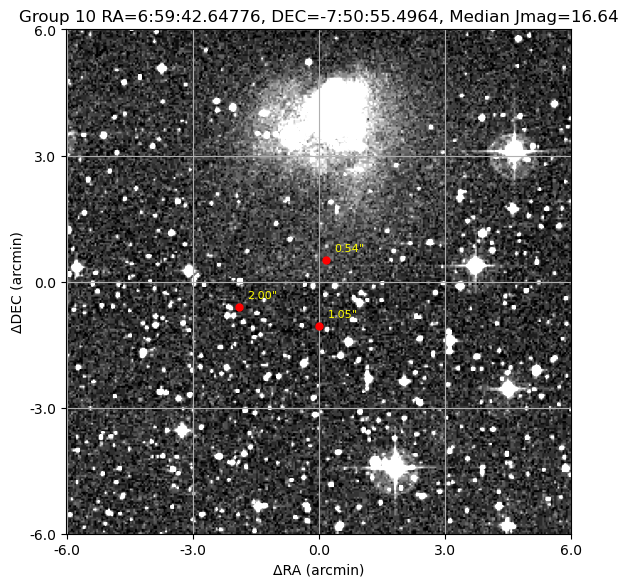

Showing: group_11_preview_NGC_2316.png


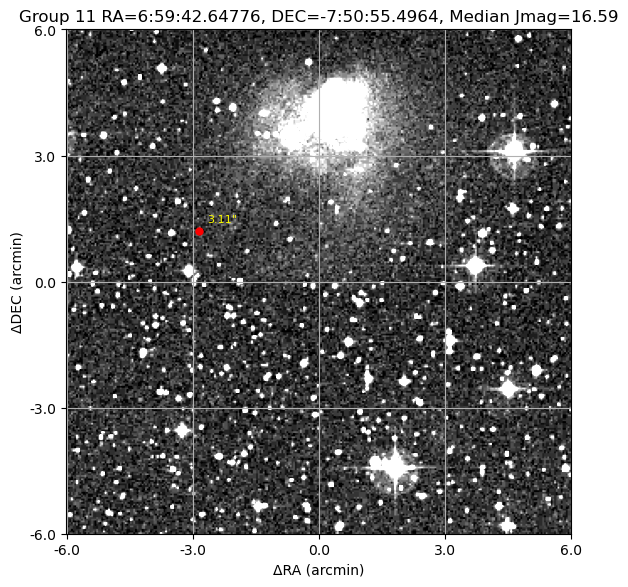

Showing: group_12_preview_NGC_2316.png


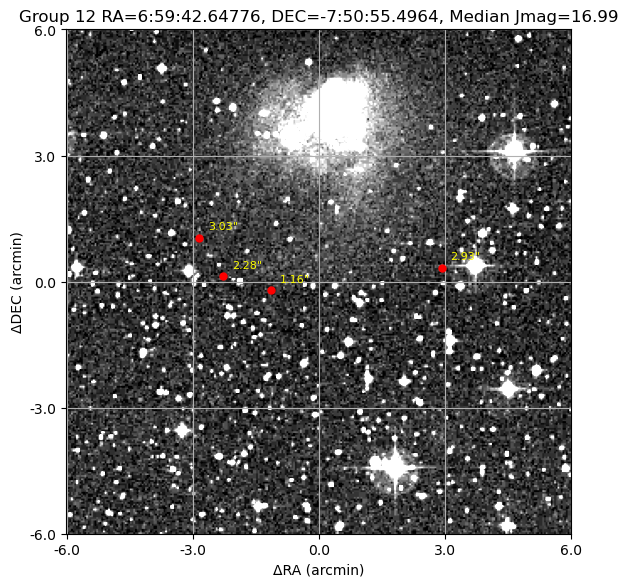

Showing: group_1_preview_NGC_2316.png


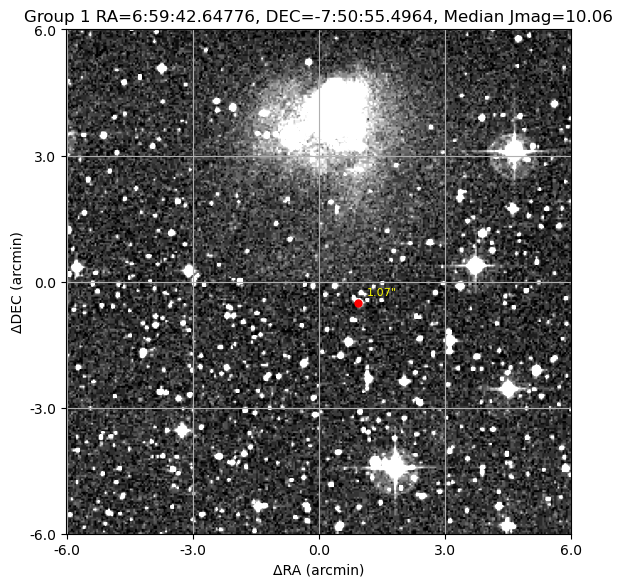

Showing: group_2_preview_NGC_2316.png


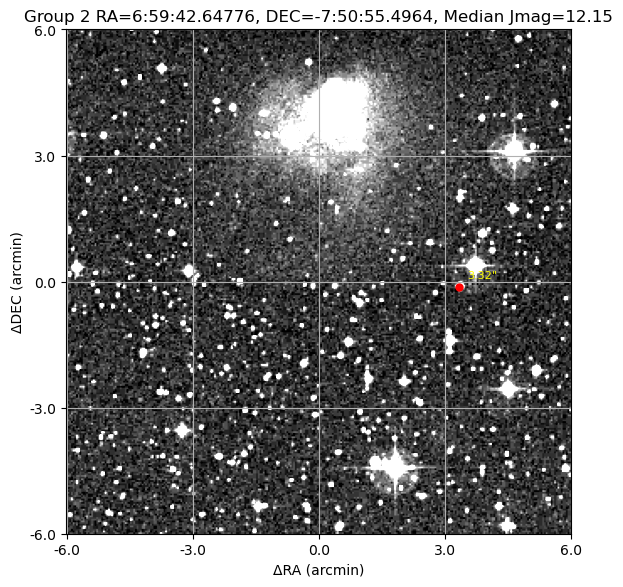

Showing: group_3_preview_NGC_2316.png


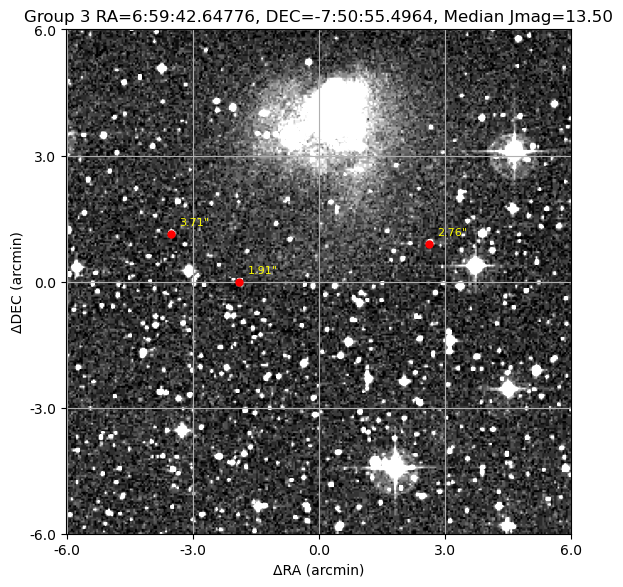

Showing: group_4_preview_NGC_2316.png


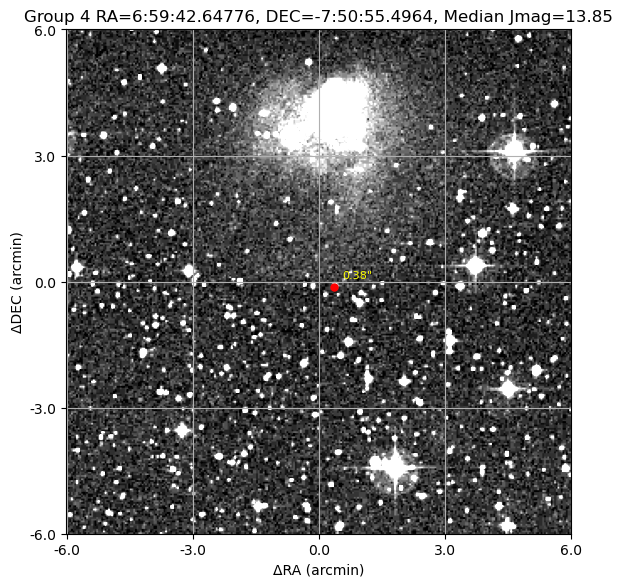

Showing: group_5_preview_NGC_2316.png


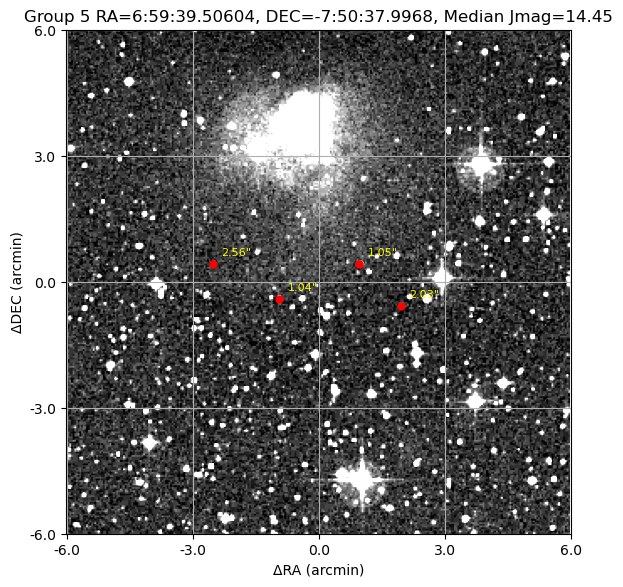

Showing: group_6_preview_NGC_2316.png


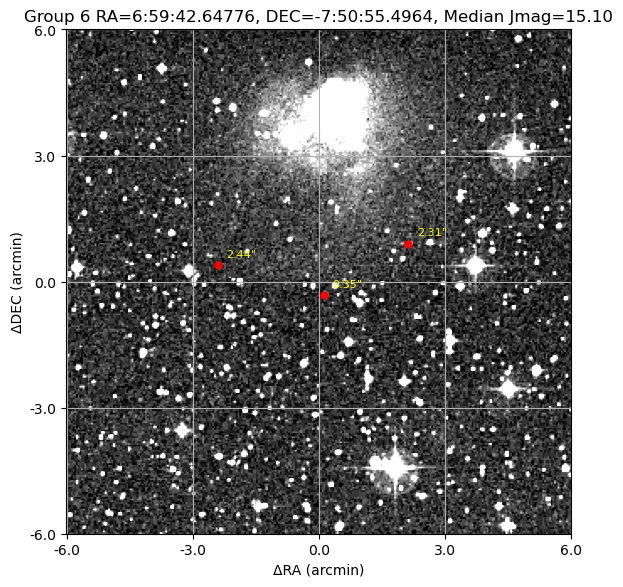

Showing: group_7_preview_NGC_2316.png


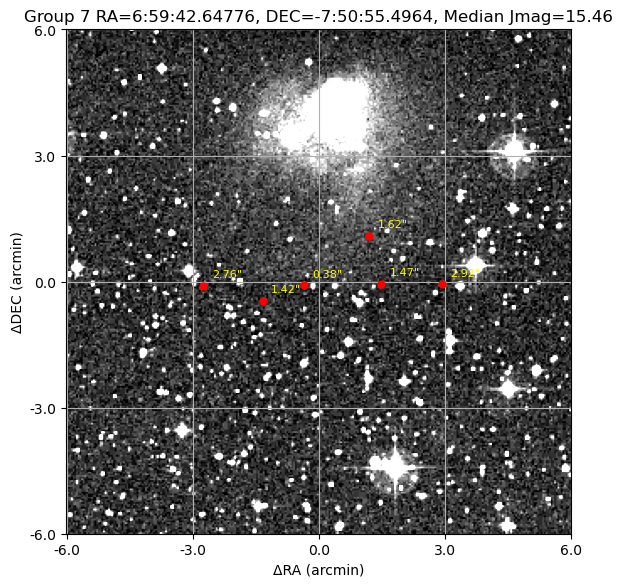

Showing: group_8_preview_NGC_2316.png


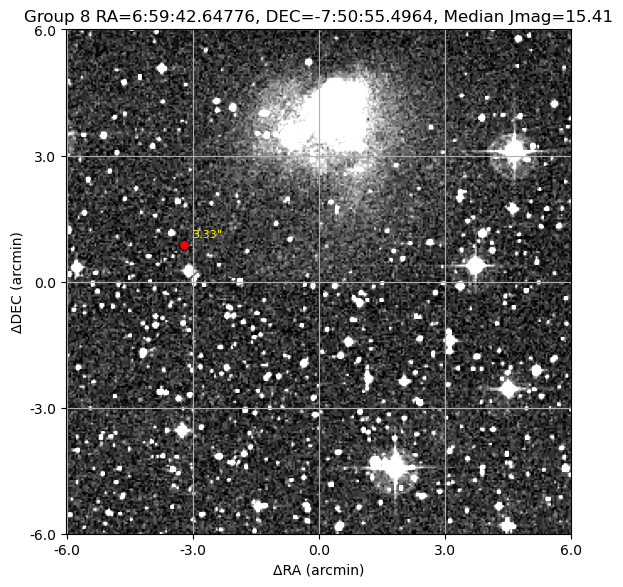

Showing: group_9_preview_NGC_2316.png


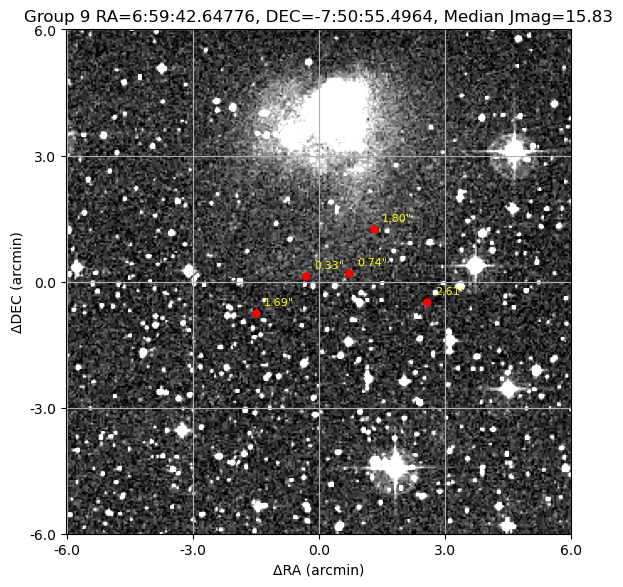

In [79]:
preview_dir = os.path.join(main_dir, f"fits_previews_{source_name}")
png_files = sorted(glob.glob(os.path.join(preview_dir, "*.png")))

print(f" Displaying {len(png_files)} preview images from: {preview_dir}\n")

for png in png_files:
    print(f"Showing: {os.path.basename(png)}")
    display(Image(filename=png))
